 # Schools_SynthPops
 This notebook is intended to prepare the school data needed by the `generate_synthetic_population` function of [Synthpops](https://docs.idmod.org/projects/synthpops/en/latest/index.html)
 
 ## Useful Links
 ### Data and data interpreation
 [Open Data](https://dati.istruzione.it/opendata/) <br>
 [Codici Meccanografici](http://www.comuni-italiani.it/001/scuole/)<br>
 [atenei](http://dati.ustat.miur.it/dataset/iscritti/resource/69bd8bbe-73b8-4f00-b0cc-7a6511d87d23http://dati.ustat.miur.it/dataset/iscritti/resource/69bd8bbe-73b8-4f00-b0cc-7a6511d87d23)
 ### History of italian provinces
 [Sud Sardegna](https://it.wikipedia.org/wiki/Provincia_del_Sud_Sardegna)<br>
 [Olbia-Tempio](https://it.wikipedia.org/wiki/Provincia_di_Olbia-Tempio)<br>
 [Ogliastra](https://it.wikipedia.org/wiki/Ogliastra)<br>
 
 ## Ideas
 
 - With respect to ICs, which are school (infancy, elementary ad Lower) complexes whose nature (exact mechanographic code) is impossible to determine:
 > direi allora facciamo una bella media dei volumi di tutti gli asili, elementari e medie e poi dividiamo il volume degli IC per questo valore. Così otteniamo il numero di "scuole efficaci" a cui un IC corrisponde

In [1]:
import pandas as pd
import numpy as np
import ast
import copy
from collections import defaultdict
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import math

## School Size Distribution

In [2]:
# load abbreviation-province name dataset
code_province_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Administrative\ItalianProvinces.csv")
code_province_df["abbreviation"] = ["NA" if pd.isnull(abbr) else abbr for abbr in code_province_df["abbreviation"]]
code_province_df.head()

,code,name,population,abbreviation
0,1,Torino,2252379,TO
1,2,Vercelli,170296,VC
2,3,Novara,368040,NO
3,4,Cuneo,586568,CN
4,5,Asti,213216,AT


In [3]:
# load school order-mechanographic codes dataset
ORD_MEC_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\school_size_distribution\ORDINESCOL2_MEC.tsv", sep = "\t")
ORD_MEC_df["MEC"] = [ast.literal_eval(string) for string in ORD_MEC_df["MEC"]]
ORD_MEC_df

,ORDINESCOL2,MEC
0,PRI,[EE]
1,PRE,[AA]
2,LOW,[MM]
3,UPP,"[PQ, PM, RC, RH, RI, RS, RH, RA , TD, SD, TA, ..."


In [4]:
# utility function
def dct_to_kv_pairs(dct):
    return [(list(dct.keys())[i], list(dct.values())[i]) for i in range(len(dct))]

In [5]:
# convert ORD_MEC_df to a more comfortable dictionary form
ORD_MEC_dct = {row[0]:row[1] for i,row in ORD_MEC_df.iterrows()}
ORD_MEC_lst = dct_to_kv_pairs(ORD_MEC_dct)

In [6]:
# load (non university) schools infrastructural data and correct incomaptibilities
scuole_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\school_size_distribution\EDICONSISTENZASTA20181920180901.csv")
scuole_df = scuole_df[scuole_df["VOLUME"] != "-"]
scuole_df["VOLUME"] = [float(volume) for volume in scuole_df["VOLUME"].tolist()] # add column "CAPIENZA_SCUOLA"
scuole_df["school_type"] = [string[2:4] for string in scuole_df["CODICESCUOLA"]] 
scuole_df.drop(["CODICEEDIFICIO","SPERFICIEAREATOTALE","SPERFICIEAREALIBERA"], axis = 1, inplace = True) #
print(scuole_df.head())
ORDINESCOL2 = []
for Type in scuole_df["school_type"].tolist():
    found = False
    if Type == "IC":
        ORDINESCOL2.append("IC")
    else:
        for tup in ORD_MEC_lst:
            if Type in tup[1]:
                ORDINESCOL2.append(tup[0])
                found = True
                break
        if not found:
            ORDINESCOL2.append("UPP")
        
scuole_df["ORDINESCOL2"] = ORDINESCOL2

scuole_df["abbreviation"]  = [string[:2] for string in scuole_df["CODICESCUOLA"]]
scuole_df["abbreviation"] = ["FC" if province == "FO" else province for province in scuole_df["abbreviation"] ]
scuole_df["abbreviation"] = ["PU" if province == "PS" else province for province in scuole_df["abbreviation"] ]
scuole_df.drop(["school_type","ANNOSCOLASTICO"], axis = 1, inplace = True)
cols = scuole_df.columns.tolist()
scuole_df = scuole_df[[cols[-1]]+[cols[0]]+[cols[-2]]+[cols[-3]]]

# groupby schools by province and order
scuole_gb_provincia_ordine_df = scuole_df.groupby(["abbreviation","ORDINESCOL2"], as_index = False).agg({"VOLUME":"sum"})
scuole_df.head()

   ANNOSCOLASTICO CODICESCUOLA   VOLUME school_type
0          201819   FGEE82302X   7000.0          EE
1          201819   COTD00101T  35000.0          TD
2          201819   CTAA08305Q    435.0          AA
3          201819   MITF11000E   9068.0          TF
5          201819   CSIS06100T  18600.0          IS


,abbreviation,CODICESCUOLA,ORDINESCOL2,VOLUME
0,FG,FGEE82302X,PRI,7000.0
1,CO,COTD00101T,UPP,35000.0
2,CT,CTAA08305Q,PRE,435.0
3,MI,MITF11000E,UPP,9068.0
5,CS,CSIS06100T,UPP,18600.0


In [7]:
# create utility dictionary
ICs_df = copy.deepcopy(scuole_df[scuole_df["ORDINESCOL2"] == "IC"])
ICs_df["count"] = [1 for i in range(len(ICs_df))]
ICs_df = ICs_df.groupby(["abbreviation"],as_index = False).agg({"count":"sum"})
ICs_per_province_dct = {row[0]:row[1] for i,row in ICs_df.iterrows() }
for abbr in code_province_df["abbreviation"]:
    try:
        ICs_per_province_dct[abbr]
    except KeyError as e:
        ICs_per_province_dct[abbr] = 1

In [8]:
# utility functions
def encapsulate(value):
    return [value]

def my_reduce(lst):
    return [lst[0]+lst[1],lst[2]+lst[3],(lst[4]+lst[5])/2.,lst[6]+lst[7]]
# this function takes as inputs the three lists (grouped in a series) containing the c_i_ic_s of the LOW, PRI and PRE school orders of a province and produces the list of the estimated s_c_i_ic of the ICs of that province (sums the first three elements and evaluates the fourth dividing the third by the second)
def sum_average(series):
    #print(series)
    zipped = list(zip(series.tolist()[0],series.tolist()[1],series.tolist()[2]))
    return [(sum(zipped[0])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]],(sum(zipped[1])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]],((sum(zipped[1])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]])/((sum(zipped[0])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]]),sum(zipped[3])]

In [9]:
%%time
# load enrolemnts per chool order and province dataset
students_by_province_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\school_size_distribution\DCIS_SCUOLE_iscritti_per_scuola_2.csv")
# drop useless columns
students_by_province_df = students_by_province_df.drop(["Flag Codes","Flags", "Seleziona anno (anno t= anno sc. t-1 / t)","TIPO_DATO_ISTR","Ordine scolastico","NATGIUR1","TIME","Gestione della scuola","ITTER107"], axis =1)


# correct incompatibiliries
students_by_province_df["Territorio"] = ["Forli'-Cesena" if province == 'Forlì-Cesena' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Massa Carrara' if province == 'Massa-Carrara' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Sud Sardegna' if province in ['Carbonia-Iglesias','Medio Campidano'] else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Sassari' if province == 'Olbia-Tempio' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Nuoro' if province == 'Ogliastra' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Trento' if province == 'Provincia Autonoma Trento' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Bolzano' if province == 'Provincia Autonoma Bolzano / Bozen' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Aosta' if province == "Valle d'Aosta / Vallée d'Aoste" else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["abbreviation"] = [couple[1] for Territorio in students_by_province_df["Territorio"].to_list() for couple in zip(code_province_df["name"].to_list(),code_province_df["abbreviation"].to_list() ) if Territorio == couple[0]]
students_by_province_df["Value"] = [encapsulate(value) for value in students_by_province_df["Value"] ] 
students_by_province_df.sort_values(by = ["abbreviation","ORDINESCOL2","Tipo dato"], inplace = True)

# groupby province and order
students_by_province_gb_df = students_by_province_df.groupby(["Territorio","abbreviation","ORDINESCOL2"], as_index = False).agg({"Value":"sum"})
students_by_province_gb_df.columns = ["Territorio","abbreviation","ORDINESCOL2","c_i_ic_s"]
sud_sardegna_post = students_by_province_gb_df[students_by_province_gb_df["Territorio"] == "Sud Sardegna"]
students_by_province_gb_df["c_i_ic_s"] = [c_i_ic_s if len(c_i_ic_s) == 4 else my_reduce(c_i_ic_s) for c_i_ic_s in students_by_province_gb_df["c_i_ic_s"]]
sud_sardegna_post2 = students_by_province_gb_df[students_by_province_gb_df["Territorio"] == "Sud Sardegna"]

# approximate for ICs
students_by_province_gb_noUPP_df = copy.deepcopy(students_by_province_gb_df[students_by_province_gb_df["ORDINESCOL2"] != "UPP"])
students_by_province_gb_noUPP_df["c_i_ic_s"] = [row[3] + [row[1]] for i,row in students_by_province_gb_noUPP_df.iterrows()]
students_by_province_gb_noUPP_gb_df = students_by_province_gb_noUPP_df.groupby(["Territorio","abbreviation"],as_index = False).agg({"c_i_ic_s":sum_average})
students_by_province_gb_noUPP_gb_df["ORDINESCOL2"] = ["IC" for i in range(len(students_by_province_gb_noUPP_gb_df))]

#concat ICs dataset with above non-ICs dataset
students_by_province_gb_df = pd.concat([students_by_province_gb_df, students_by_province_gb_noUPP_gb_df], ignore_index=True)


# merge with grouped schools dataset
scuole_gb_provincia_ordine_merged_df = scuole_gb_provincia_ordine_df.merge(right =students_by_province_gb_df , on = ["abbreviation","ORDINESCOL2"],validate = "one_to_one")
scuole_gb_provincia_ordine_merged_df["#classi/volume"] = [row[4][0]/row[2] for i,row in scuole_gb_provincia_ordine_merged_df.iterrows() ]

# evaluate approximation factors
scuole_df["#classi/volume"] = [scuole_gb_provincia_ordine_merged_df.loc[(scuole_gb_provincia_ordine_merged_df["abbreviation"] == row[0] ) & (scuole_gb_provincia_ordine_merged_df["ORDINESCOL2"] == row[2] ),"#classi/volume" ].tolist()[0] for i,row in scuole_df.iterrows()]
scuole_df["iscritti_per_classe"] = [scuole_gb_provincia_ordine_merged_df.loc[(scuole_gb_provincia_ordine_merged_df["abbreviation"] == row[0] ) & (scuole_gb_provincia_ordine_merged_df["ORDINESCOL2"] == row[2] ),"c_i_ic_s" ].tolist()[0][2] for i,row in scuole_df.iterrows()]

# evaluate enrollements and clean dataset
scuole_df["enrollments"] = scuole_df["#classi/volume"]*scuole_df["VOLUME"]*scuole_df["iscritti_per_classe"]
scuole_df.drop(["VOLUME","#classi/volume","iscritti_per_classe"], inplace = True, axis = 1)

scuole_df.head()

Wall time: 41.3 s


,abbreviation,CODICESCUOLA,ORDINESCOL2,enrollments
0,FG,FGEE82302X,PRI,55.054738
1,CO,COTD00101T,UPP,302.399635
2,CT,CTAA08305Q,PRE,3.227159
3,MI,MITF11000E,UPP,55.579344
5,CS,CSIS06100T,UPP,186.401684


In order to estimate ICs' capacity, we need to average over school orders (**ORDINESCOL2**) of **LOW**, **PRE** and **PRI** departments in every province.  

In [10]:
sum(scuole_df["enrollments"].to_list()) #merda!!

8224763.114917536

$numero_classi_scuola_provincia_ordine_volume = (numero_classi_provicia_ordine/somma_volumi_scuole_provincia_ordine)*volume$ <br>
$studenti_scuola_provincia_ordine_volume = numero_classi_scuola_provincia_ordine_volume *iscritti_per_classe_provincia_ordine$<br>

In [11]:
%%time
#l oad university data
universities_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\school_size_distribution\università_open_data.csv")

# add temporary provinces, draw from univerities names
universities_df["province"] = [name.split()[0] for name in universities_df["AteneoNOME"] ]
universities_df["province"] = ["Potenza" if province == "Basilicata" else province for province in universities_df["province"] ]
universities_df["province"] = ["Cuneo" if province == "Bra" else province for province in universities_df["province"] ]
universities_df["province"] = ["Cosenza" if province == "Calabria" else province for province in universities_df["province"] ]
universities_df["province"] = ["Macerata" if province == "Camerino" else province for province in universities_df["province"] ]
universities_df["province"] = ["Bari" if province == "Casamassima" else province for province in universities_df["province"] ]
universities_df["province"] = ["Frosinone" if province == "Cassino" else province for province in universities_df["province"] ]
universities_df["province"] = ["Varese" if province == "Castellanza" else province for province in universities_df["province"] ]
universities_df["province"] = ["Verbano-Cusio-Ossola" if province == "Insubria" else province for province in universities_df["province"] ]
universities_df["province"] = ["Ancona" if province == "Marche" else province for province in universities_df["province"] ]
universities_df["province"] = ["Campobasso" if province == "Molise" else province for province in universities_df["province"] ]
universities_df["province"] = ["Como" if province == "Novedrate" else province for province in universities_df["province"] ]
universities_df["province"] = ["Vercelli" if province == "Piemonte" else province for province in universities_df["province"] ]
universities_df["province"] = ["Reggio di Calabria" if province == "Reggio" else province for province in universities_df["province"] ]
universities_df["province"] = ["Milano" if province == "Rozzano" else province for province in universities_df["province"] ]
universities_df["province"] = ["Lecce" if province == "Salento" else province for province in universities_df["province"] ]
universities_df["province"] = ["Benevento" if province == "Sannio" else province for province in universities_df["province"] ]
universities_df["province"] = ["Roma" if province == "Torrevecchia" else province for province in universities_df["province"] ]
universities_df["province"] = ["Viterbo" if province == "Tuscia" else province for province in universities_df["province"] ]
universities_df["province"] = ["Pesaro e Urbino" if province == "Urbino" else province for province in universities_df["province"] ]

# associate province abbreviation based on temporary names
universities_df_abbreviation = [] #
found = False
universities_provinces = set(universities_df["province"])
#provice_abbreviations = set(code_province_df[""])
for j,rowj in universities_df.iterrows():
    found = False
    for i, rowi in code_province_df.iterrows():
        if rowj["province"].lower() == rowi["name"].lower():
            universities_df_abbreviation.append(rowi["abbreviation"])
            found = True
            break
    if not found:
        universities_df_abbreviation.append("-")
        
universities_df["abbreviation"] = universities_df_abbreviation 
print("malformed  = ", len(universities_df[universities_df["abbreviation"] == "-"]))


# prepare university dataset for concat with scuole_df
universities_gb_df = universities_df.groupby(["abbreviation", "AteneoNOME"], as_index = False).agg({"Isc":"sum"})
universities_gb_df["ORDINESCOL2"] = ["UNI" for i in range(len(universities_gb_df))] 
universities_gb_df.columns = ["abbreviation", "CODICESCUOLA", "enrollments", "ORDINESCOL2"]
cols = universities_gb_df.columns
universities_gb_df.columns = [[cols[0]]+ [cols[1]]+ [cols[2]]+[cols[3]]]
# i don't know
universities_gb_df.columns = universities_gb_df.columns.to_flat_index()
universities_gb_df.columns  = pd.Index([col[0] for col in universities_gb_df.columns])
# universi

print(universities_gb_df.head())
# print("\n ---------------------- \n")
# print('len(set(universities_df["ClasseNUMERO"])) = ',len(set(universities_df["ClasseNUMERO"])))
# print('len(set(universities_df["ClasseNOME"])) = ',len(set(universities_df["ClasseNOME"])))

malformed  =  0
  abbreviation      CODICESCUOLA  enrollments ORDINESCOL2
0           AN            Marche        14980         UNI
1           AO             Aosta         1021         UNI
2           AQ          L'Aquila        15965         UNI
3           BA              Bari        42673         UNI
4           BA  Bari Politecnico         9824         UNI
Wall time: 29.6 s


In [12]:
all_schools_df = pd.concat([universities_gb_df,scuole_df], ignore_index = True)
all_schools_df

,abbreviation,CODICESCUOLA,enrollments,ORDINESCOL2
0,AN,Marche,14980.000000,UNI
1,AO,Aosta,1021.000000,UNI
2,AQ,L'Aquila,15965.000000,UNI
3,BA,Bari,42673.000000,UNI
4,BA,Bari Politecnico,9824.000000,UNI
...,...,...,...,...
56649,VE,VEIC838006,440.928297,IC
56650,BO,BOEE825026,142.613123,PRI
56651,VI,VIEE81202C,7.251542,PRI
56652,TO,TOAA029022,62.779123,PRE


In [13]:
sum(all_schools_df["enrollments"].tolist()) # it is roughly correct. see istat data

9883033.114917684

In [14]:
all_schools_df.sort_values(by = ["enrollments"], inplace = True,ascending = False)

In [15]:
all_schools_df.head(50)

,abbreviation,CODICESCUOLA,enrollments,ORDINESCOL2
59,RM,Roma La Sapienza,102049.000000,UNI
9,BO,Bologna,80428.000000,UNI
41,NA,Napoli Federico II,73741.000000,UNI
75,TO,Torino,73049.000000,UNI
31,MI,Milano,59353.000000,UNI
47,PD,Padova,58720.000000,UNI
23,FI,Firenze,51633.000000,UNI
36,MI,Milano Politecnico,44923.000000,UNI
50,PI,Pisa,44900.000000,UNI
3,BA,Bari,42673.000000,UNI


In [16]:
enr = all_schools_df["enrollments"].tolist()

In [17]:
len(enr)

56654

In [18]:
math.exp(1)

2.718281828459045

In [19]:
bins = np.logspace(0,math.log(max(enr),math.exp(1)),base= math.exp(1), num = 100)

In [20]:
len(bins)

100

In [21]:
# total = len()
# def get_freq(data, total):
#     return sum(data)/total

In [22]:
def get_school_size_synth(df, abbr,num = 50, base = math.exp(1)):
    abbr_df = df[df["abbreviation"] == abbr]
    data = df["enrollments"].tolist()
    bins = np.logspace(0,math.log(max(enr),base),base= base,num = num)
    distrib =  binned_statistic(data, data, statistic = "count", bins=bins)
    counts = distrib[0]
    edges = distrib[1]
    temp_df = pd.DataFrame({"school_size": [[round(edges[i]),round(edges[i+1])] for i in range(len(edges)-1)], "percent":[count/sum(counts) for count in counts]})
    n = 0
    for i,row in temp_df.iterrows():
        if row["school_size"][1] >= 50:
            n = i
            break
    first_n_df = temp_df[:n+1]
    row = pd.DataFrame({"school_size":str(first_n_df["school_size"][0][0])+"_"+str(first_n_df["school_size"].tolist()[-1][1]),"percent":sum(first_n_df["percent"].tolist())}, index = [0])
    temp_df["school_size"] = [str(lst[0])+"_"+str(lst[1]) for lst in temp_df["school_size"] ]
    return pd.concat([row,temp_df[n+1:]], ignore_index = True)

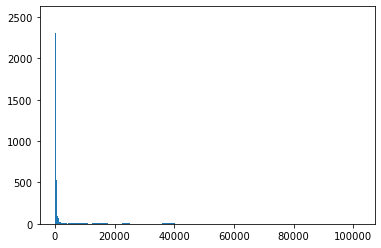

In [23]:
plt.hist(all_schools_df["enrollments"].tolist(), bins = bins)
plt.show()

In [24]:
max(all_schools_df["enrollments"].tolist())

102049.0

In [25]:
distrib = get_school_size_synth(all_schools_df,abbr = "TO", num = 15, base = 10)

In [26]:
distrib

,school_size,percent
0,1_61,0.359816
1,61_140,0.294778
2,140_319,0.254710
3,319_728,0.078123
4,728_1659,0.009183
5,1659_3782,0.001572
6,3782_8620,0.000600
7,8620_19646,0.000671
8,19646_44775,0.000406
9,44775_102049,0.000141


In [27]:
code_province_df

,code,name,population,abbreviation
0,1,Torino,2252379,TO
1,2,Vercelli,170296,VC
2,3,Novara,368040,NO
3,4,Cuneo,586568,CN
4,5,Asti,213216,AT
...,...,...,...,...
102,103,Verbano-Cusio-Ossola,157455,VB
103,108,Monza e della Brianza,878267,MB
104,109,Fermo,173004,FM
105,110,Barletta-Andria-Trani,388390,BT


In [28]:
#E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\school_size_distribution\school_size_distribution
for i,row in code_province_df.iterrows():
    to_be_saved = get_school_size_synth(all_schools_df,abbr = row["abbreviation"], num = 15, base = 10)
    to_be_saved.to_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\school_size_distribution\school_size_distribution\\"+str(row["code"])+".csv", index = False)

## Enrollment by age
Since we would anyway have university enrollment by age stratified per age class, we decided to use more recent data (which forces us to stratify by age class) also for sub-university enrollemnt by age (we could have used, for the latter, te census data which have singleton age classes (see deprecated_data folder))  

In [43]:
#load 2018 enrollment_by_age_province_absolute dataset
enrollment_by_age_province_absolute = pd.read_csv(r"E:\IlMioDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\enrollment_rate\enrollment_by_age_province_absolute.csv")
enrollment_by_age_province_absolute.drop(["ITTER107","TIPO_DATO_ISTR","Tipo dato","Ordine scolastico","NATGIUR1","Gestione della scuola","TIME","Seleziona anno (anno t= anno sc. t-1 / t)","Flag Codes","Flags"], axis = 1, inplace = True)
enrollment_by_age_province_absolute["Territorio"] = ['Sud Sardegna' if ter  in ['Carbonia-Iglesias','Medio Campidano'] else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ["Forli'-Cesena" if ter  == 'Forlì-Cesena' else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ['Massa Carrara' if ter  == 'Massa-Carrara' else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ['Nuoro' if ter  == 'Ogliastra' else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ['Sassari' if ter  == 'Olbia-Tempio' else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ['Aosta' if ter  == "Valle d'Aosta / Vallée d'Aoste" else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ['Bolzano' if ter  == 'Provincia Autonoma Bolzano / Bozen' else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
enrollment_by_age_province_absolute["Territorio"] = ['Trento' if ter  == 'Provincia Autonoma Trento' else ter for ter in enrollment_by_age_province_absolute["Territorio"]]
# check integrity
print(set(enrollment_by_age_province_absolute["Territorio"])-set(code_province_df["name"]))
print(set(code_province_df["name"])-set(enrollment_by_age_province_absolute["Territorio"]))
enrollment_by_age_province_absolute.head()

set()
set()


,Territorio,ORDINESCOL2,Value
0,Torino,LOW,61579
1,Vercelli,LOW,4288
2,Biella,LOW,4306
3,Verbano-Cusio-Ossola,LOW,4022
4,Novara,LOW,10241


In [57]:
set(enrollment_by_age_province_absolute["ORDINESCOL2"])

{'LOW', 'PRE', 'PRI', 'UPP'}

In [56]:
#load 2020 population_per_age_province dataset
population_per_age_province = pd.read_csv(r"E:\IlMioDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\enrollment_rate\population_per_age_province.csv")
population_per_age_province.drop(["ITTER107","TIPO_DATO15","Tipo di indicatore demografico","SEXISTAT1","Sesso","ETA1","STATCIV2","Stato civile","TIME","Seleziona periodo","Flag Codes","Flags"], axis = 1, inplace = True)
population_per_age_province["Territorio"] = ['Sud Sardegna' if ter  in ['Carbonia-Iglesias','Medio Campidano'] else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ["Forli'-Cesena" if ter  == 'Forlì-Cesena' else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ['Massa Carrara' if ter  == 'Massa-Carrara' else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ['Nuoro' if ter  == 'Ogliastra' else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ['Sassari' if ter  == 'Olbia-Tempio' else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ['Aosta' if ter  == "Valle d'Aosta / Vallée d'Aoste" else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ['Bolzano' if ter  == 'Provincia Autonoma Bolzano / Bozen' else ter for ter in population_per_age_province["Territorio"]]
population_per_age_province["Territorio"] = ['Trento' if ter  == 'Provincia Autonoma Trento' else ter for ter in population_per_age_province["Territorio"]]
#inregrity check
print(set(population_per_age_province["Territorio"])-set(code_province_df["name"]))
print(set(code_province_df["name"])-set(population_per_age_province["Territorio"]))

# techinicality over Età column
population_per_age_province["Età"]  =  [int(Età.split()[0]) for Età in population_per_age_province["Età"] ]
population_per_age_province

set()
set()


,Territorio,Età,Value
0,Torino,0,14648
1,Vercelli,0,1033
2,Biella,0,923
3,Verbano-Cusio-Ossola,0,808
4,Novara,0,2537
...,...,...,...
10802,Sud Sardegna,61,5367
10803,Sud Sardegna,19,3140
10804,Sud Sardegna,98,110
10805,Sud Sardegna,86,1961


In [ ]:
def group_by_order(df, age_column = "Età", )